# MODEL OLUŞTURMA

__HAM VERİ GÖRSELLEŞTİRME__

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../data/preprocessed_review.csv")

In [4]:
def label_review(rate):
    if rate >= 4: return 'positive'
    elif rate == 3: return 'neutral'
    else: return 'negative'

df['sentiment'] = df['Puan'].apply(label_review)

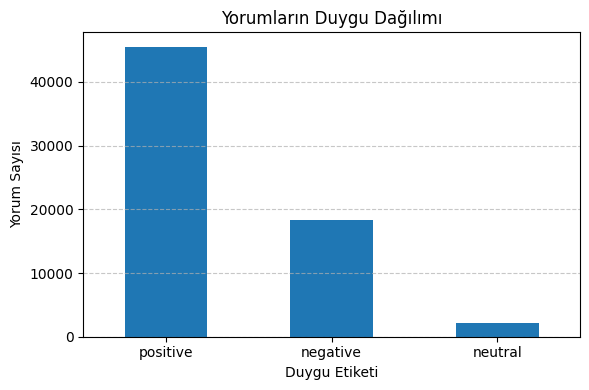

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
df['sentiment'].value_counts().plot(kind='bar')

plt.title('Yorumların Duygu Dağılımı')
plt.xlabel('Duygu Etiketi')
plt.ylabel('Yorum Sayısı')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


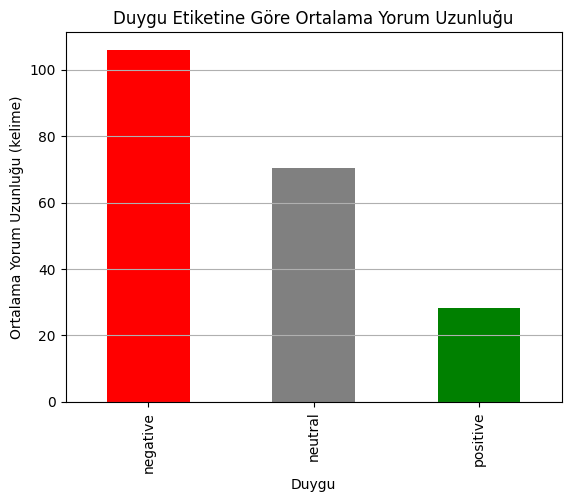

In [6]:
df["review_length"] = df["lemmas"].apply(len)

df.groupby("sentiment")["review_length"].mean().reindex(["negative", "neutral", "positive"]).plot(
    kind="bar", color=["red", "gray", "green"]
)
plt.title("Duygu Etiketine Göre Ortalama Yorum Uzunluğu")
plt.xlabel("Duygu")
plt.ylabel("Ortalama Yorum Uzunluğu (kelime)")
plt.grid(axis='y')
plt.show()

# SENTIMENT ANALYSIS

__transformation tabanlı model analizi__

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_name = "tabularisai/multilingual-sentiment-analysis"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

sentiment_pipe = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


Device set to use cuda:0


In [8]:
import ast

texts = df["lemmas"].dropna().apply(lambda x: " ".join(ast.literal_eval(x))).tolist()
results = sentiment_pipe(texts, batch_size=128)

In [9]:
df["pred_label"] = [res["label"] for res in results]
df["pred_score"] = [res["score"] for res in results]

In [10]:
def normalize_label(label):
    label = label.lower()
    if "neg" in label:
        return "negative"
    elif "notr" in label or "neutral" in label:
        return "neutral"
    elif "pos" in label:
        return "positive"
    return "unknown"

df["normalized_pred_label"] = df["pred_label"].apply(normalize_label)

In [11]:
import ast

positive_keywords = ["süper", "harika", "mükemmel", "çok güzel", "teşekkür", "bayıldım", "efsane", "beğen"]

def force_positive(row):
    text = " ".join(ast.literal_eval(row["lemmas"])) if isinstance(row["lemmas"], str) else " ".join(row["lemmas"])
    if any(kw in text for kw in positive_keywords) or "unlost" in text:
        return "positive"
    return row["normalized_pred_label"]

df["normalized_pred_label"] = df.apply(force_positive, axis=1)

__Kullandığımız modele göre negative ve pozitiflerde oldukça iyi sonuçlar elde ettik ancak neutral verinin azlığından dolayı bu alanda neredeyse hiç doğru tahminimiz yok__

In [12]:
from sklearn.metrics import classification_report
print(classification_report(df["sentiment"], df["normalized_pred_label"]))

              precision    recall  f1-score   support

    negative       0.67      0.62      0.65     18255
     neutral       0.07      0.24      0.10      2205
    positive       0.90      0.81      0.86     45502

    accuracy                           0.74     65962
   macro avg       0.55      0.56      0.54     65962
weighted avg       0.81      0.74      0.77     65962



In [13]:
df

,lemmas,Puan,Tarih,sentiment,review_length,pred_label,pred_score,normalized_pred_label
0,"['şua', 'sorun', 'var', 'banka', 'kart', 'para...",1,2025-07-07 10:25:20,negative,164,Very Negative,0.361278,negative
1,"['türlü', 'dekont', 'yer', 'öde', 'dair', 'dek...",1,2025-07-07 09:08:45,negative,95,Neutral,0.458569,neutral
2,"['hafta', 'çalışıyum', 'güvenlik', 'anahtar', ...",1,2025-07-06 22:22:35,negative,144,Negative,0.319527,positive
3,"['yabancı', 'doğrula']",1,2025-07-06 20:02:06,negative,22,Neutral,0.287212,neutral
4,"['şifre', 'güncelle', 'guncelletmiuorsunuz', '...",3,2025-07-06 18:34:42,neutral,52,Very Negative,0.242290,negative
...,...,...,...,...,...,...,...,...
65957,['güzel'],5,2017-08-25 10:43:11,positive,9,Positive,0.535535,positive
65958,"['mobil', 'öde', 'bakiye', 'işlem', 'tarihçe',...",5,2017-08-19 15:08:30,positive,82,Positive,0.397282,positive
65959,['besleme'],4,2017-08-17 06:38:45,positive,11,Neutral,0.320637,neutral
65960,"['fin', 'hit']",5,2017-08-16 20:23:34,positive,14,Positive,0.460449,positive


In [14]:
df[["sentiment","normalized_pred_label"]]

,sentiment,normalized_pred_label
0,negative,negative
1,negative,neutral
2,negative,positive
3,negative,neutral
4,neutral,negative
...,...,...
65957,positive,positive
65958,positive,positive
65959,positive,neutral
65960,positive,positive


__data klasöründen tüm veriye erişilebilir__

In [15]:
df[["lemmas", "sentiment", "review_length", "normalized_pred_label", "Tarih"]].to_csv("../data/sentiment_results.csv", index=False)

__burada görünümün daha anlaşılır olabilmesi için sentiment ve pred_sentimentin renklendirilip daha iyi görünüm sağlandı__

In [16]:
import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import PatternFill

df[["lemmas", "sentiment", "normalized_pred_label", "Tarih"]].to_excel("../data/sentiment_results.xlsx", index=False)

wb = load_workbook("../data/sentiment_results.xlsx")
ws = wb.active

colors = {
    "neutral": "D9D9D9", 
    "positive": "C6EFCE", 
    "negative": "F2DCDB", 
}

for row in range(2, ws.max_row + 1):
    sentiment = ws[f"B{row}"].value 
    pred = ws[f"C{row}"].value      
    if sentiment in colors:
        fill_true = PatternFill(start_color=colors[sentiment], end_color=colors[sentiment], fill_type="solid")
        ws[f"B{row}"].fill = fill_true
    if pred in colors:
        fill_pred = PatternFill(start_color=colors[pred], end_color=colors[pred], fill_type="solid")
        ws[f"C{row}"].fill = fill_pred

wb.save("../data/sentiment_results_colored.xlsx")

__NEGATIF YORUMLARDA ONERI KISMI__

In [18]:
samples = df[df['sentiment'] == 'negative'].sample(200, random_state=42)[['lemmas']]
samples['lemmas_text'] = samples['lemmas'].apply(lambda x: " ".join(eval(x)))
samples['yapici_mi'] = ''  # elle 1 (yapıcı), 0 (değil) dolduracaksın
samples.to_csv("yapici_egitim_seti.csv", index=False)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# CSV'yi yükle
df_labeled = pd.read_csv("etiketlenecek_yapici_negatifler.csv")
X_text = df_labeled['lemmas_text']
y = df_labeled['yapici_mi']

# Vektörleştir
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(X_text)

# Eğitim ve test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Değerlendirme
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
